## Baseline

Rolling AR(1)-style Linear Regression (window=W) — TEST ONLY (last 20%)
Test R²   = 0.9121
Test RMSE = 0.2267
Test MAE  = 0.1385
# of Test Predictions = 531


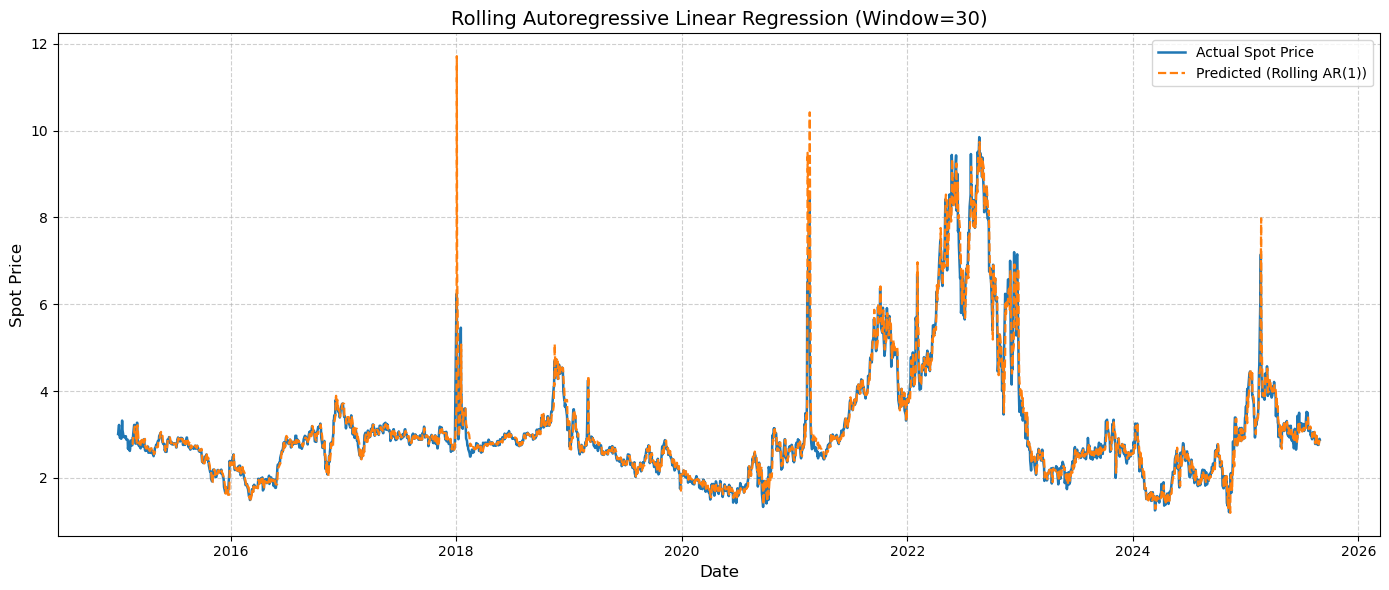

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'merged_data5.csv'
df = pd.read_csv(file_path)

df = df.dropna(subset=['Spot_Price']).reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

prices = df['Spot_Price'].values
dates = df['Date'].values

W = 30

predictions = []
actuals = []
prediction_dates = []

model = LinearRegression()

for t in range(W, len(prices)):
    X_train = prices[t - W:t - 1].reshape(-1, 1)
    y_train = prices[t - W + 1:t]
    
    model.fit(X_train, y_train)
    
    X_test = prices[t - 1].reshape(1, -1)
    y_pred = model.predict(X_test)[0]
    
    predictions.append(y_pred)
    actuals.append(prices[t])
    prediction_dates.append(dates[t])

predictions = np.array(predictions)
actuals = np.array(actuals)
prediction_dates = np.array(prediction_dates)

# ================================================
# Evaluate ONLY on last 20% of the original dataset
# ================================================
test_start_index = int(0.8 * len(prices))  # threshold in original series
mask_test = prediction_dates >= dates[test_start_index]  # align based on dates

test_r2 = r2_score(actuals[mask_test], predictions[mask_test])
test_rmse = np.sqrt(mean_squared_error(actuals[mask_test], predictions[mask_test]))
test_mae = mean_absolute_error(actuals[mask_test], predictions[mask_test])

print("Rolling AR(1)-style Linear Regression (window=W) — TEST ONLY (last 20%)")
print(f"Test R²   = {test_r2:.4f}")
print(f"Test RMSE = {test_rmse:.4f}")
print(f"Test MAE  = {test_mae:.4f}")
print(f"# of Test Predictions = {mask_test.sum()}")

# ==============================
# Plot (optional, unchanged)
# ==============================
plt.figure(figsize=(14, 6))
plt.plot(dates, prices, label='Actual Spot Price', color='tab:blue', linewidth=1.8)
plt.plot(prediction_dates, predictions, label='Predicted (Rolling AR(1))', color='tab:orange', linestyle='--', linewidth=1.6)
plt.title(f'Rolling Autoregressive Linear Regression (Window={W})', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spot Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm

# Load and Prepare Data 
file_path = "merged_data5.csv"
df = pd.read_csv(file_path)

# Clean: drop ANY NaN row across ALL columns, then sort by Date ascending
df = df.dropna().reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

target = "Spot_Price"
exclude_cols = ["Date", target]
feature_cols = [c for c in df.columns if c not in exclude_cols]

prices = df[target].values
features = df[feature_cols].values
n = len(df)
W = 30  # rolling window

test_start = int(0.8 * n)  # last 20%
print(f"Train rows (for reporting cut): {test_start}, Test rows: {n - test_start}")

pred_all, act_all, idx_all = [], [], []
model = LinearRegression()

for t in tqdm(range(W, n)):
    # Build training window with lagged price + features
    X_train_lag  = prices[t - W:t - 1].reshape(-1, 1)
    X_train_feat = features[t - W:t - 1]
    X_train = np.hstack([X_train_lag, X_train_feat])
    y_train = prices[t - W + 1:t]
    model.fit(X_train, y_train)

    # Predict next point using last observed price & features
    X_test_lag  = prices[t - 1].reshape(1, -1)
    X_test_feat = features[t - 1].reshape(1, -1)
    X_test = np.hstack([X_test_lag, X_test_feat])
    y_pred = model.predict(X_test)[0]

    pred_all.append(y_pred)
    act_all.append(prices[t])
    idx_all.append(t)

pred_all = np.array(pred_all)
act_all = np.array(act_all)
idx_all = np.array(idx_all)

# Evaluate ONLY last 20% of original index space
mask_test_all = idx_all >= test_start
r2_all   = r2_score(act_all[mask_test_all], pred_all[mask_test_all])
rmse_all = np.sqrt(mean_squared_error(act_all[mask_test_all], pred_all[mask_test_all]))
mae_all  = mean_absolute_error(act_all[mask_test_all], pred_all[mask_test_all])

print("\n=== AR(1) + All Features Baseline — Test Only (last 20%) ===")
print(f"Test R²   = {r2_all:.4f}")
print(f"Test RMSE = {rmse_all:.4f}")
print(f"Test MAE  = {mae_all:.4f}")
print(f"# Predictions in Test: {mask_test_all.sum()}\n")


Train rows (for reporting cut): 2117, Test rows: 530


100%|██████████| 2617/2617 [00:00<00:00, 3558.54it/s]


=== AR(1) + All Features Baseline — Test Only (last 20%) ===
Test R²   = -8.9578
Test RMSE = 2.4045
Test MAE  = 1.1260
# Predictions in Test: 530



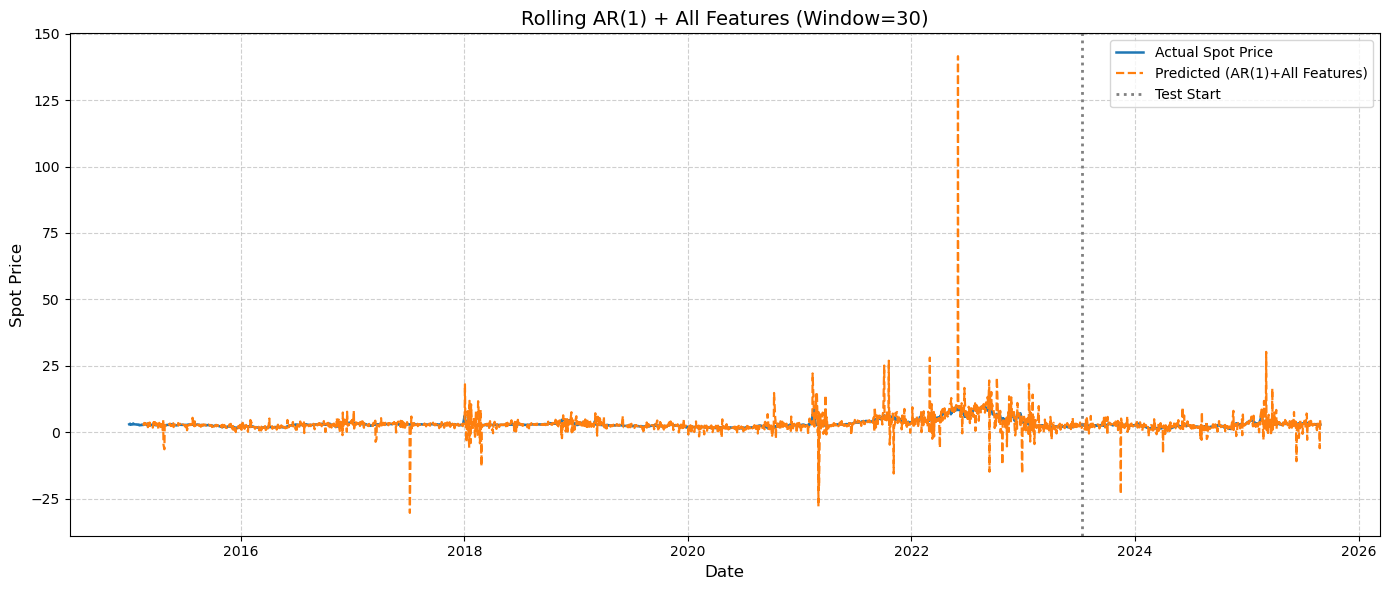

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(dates, prices, label="Actual Spot Price", color="tab:blue", linewidth=1.8)
plt.plot(date_all, pred_all, label="Predicted (AR(1)+All Features)", color="tab:orange", linestyle="--", linewidth=1.6)

# Highlight test region
plt.axvline(x=dates[test_start], color="gray", linestyle=":", linewidth=2, label="Test Start")

plt.title(f"Rolling AR(1) + All Features (Window={W})", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Clean x-axis date formatting
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


## Correlation Filtering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter

file_path = 'merged_data5.csv'
df = pd.read_csv(file_path)
df = df.dropna(subset=['Spot_Price']).reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Date range: {df['Date'].min()} → {df['Date'].max()}")

W = 30  # rolling window size
exclude_cols = ['Date', 'Spot_Price']
all_feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"\nAll candidate features ({len(all_feature_cols)}): {all_feature_cols}")

print("\n" + "="*50)
print("GLOBAL CORRELATION FILTERING (Target vs Feature)")
print("="*50)

correlations = {}
for col in all_feature_cols:
    if df[col].isna().sum() == 0:
        corr, p_value = pearsonr(df['Spot_Price'], df[col])
        correlations[col] = {
            'correlation': corr,
            'p_value': p_value,
            'abs_correlation': abs(corr)
        }

sorted_features = sorted(correlations.items(), key=lambda x: x[1]['abs_correlation'], reverse=True)
print("\nTop 10 most correlated features:")
print("-" * 60)
print(f"{'Feature':<30} {'Correlation':<12} {'P-value':<12}")
print("-" * 60)
for feature, stats in sorted_features[:10]:
    print(f"{feature:<30} {stats['correlation']:<12.4f} {stats['p_value']:<12.4f}")

threshold = 0.2
print(f"\n--- Applying correlation threshold: {threshold} ---")
selected_features = [f for f, s in correlations.items() if s['abs_correlation'] > threshold]
print(f"Selected {len(selected_features)} features (|corr| > {threshold})")
for f in selected_features:
    print(f"  {f}: {correlations[f]['correlation']:.4f}")

prices = df['Spot_Price'].values
dates = df['Date'].values
features = df[selected_features].values

predictions, actuals, prediction_dates = [], [], []
model = LinearRegression()

for t in range(W, len(prices)):
    X_train_lag = prices[t - W:t - 1].reshape(-1, 1)
    X_train_feat = features[t - W:t - 1]
    X_train = np.hstack([X_train_lag, X_train_feat])
    y_train = prices[t - W + 1:t]

    model.fit(X_train, y_train)

    X_test_lag = prices[t - 1].reshape(1, -1)
    X_test_feat = features[t - 1].reshape(1, -1)
    X_test = np.hstack([X_test_lag, X_test_feat])
    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(prices[t])
    prediction_dates.append(dates[t])

predictions = np.array(predictions)
actuals = np.array(actuals)
prediction_dates = np.array(prediction_dates)

r2 = r2_score(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print("\nFINAL RESULTS")
print("="*40)
print(f"R²   = {r2:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"Selected features: {selected_features}")

def window_selection_stats(df, feature_cols, spot_col='Spot_Price', W=30, threshold=0.2):
    prices = df[spot_col].to_numpy()
    freq = Counter()
    n_windows = 0

    for t in range(W, len(df)):
        idx_train = np.arange(t - W, t - 1)
        y_train = prices[idx_train + 1]
        Xw = df.loc[idx_train, feature_cols].copy().ffill().bfill()

        selected_window = []
        for col in feature_cols:
            x = Xw[col].to_numpy()
            if np.isnan(x).all() or np.nanstd(x) == 0:
                continue
            try:
                r, _ = pearsonr(x, y_train)
            except Exception:
                r = np.corrcoef(x, y_train)[0, 1]
            if np.isfinite(r) and abs(r) > threshold:
                selected_window.append(col)

        for col in selected_window:
            freq[col] += 1
        n_windows += 1

    rows = []
    for col in feature_cols:
        f = freq[col]
        rate = f / n_windows if n_windows > 0 else 0
        rows.append({"Feature": col, "Frequency": f, "Selection Rate": round(rate, 4)})
    out = pd.DataFrame(rows).sort_values(["Frequency", "Selection Rate"],
                                         ascending=[False, False]).reset_index(drop=True)
    return out, n_windows

freq_df, total_windows = window_selection_stats(df, all_feature_cols,
                                                spot_col='Spot_Price',
                                                W=W, threshold=threshold)
print(f"\nTotal rolling windows analyzed: {total_windows}")
print("\nTop 10 features by selection frequency:")
print(freq_df.head(10).to_string(index=False))

freq_df.to_csv(f"feature_selection_frequency_threshold_{threshold}.csv", index=False)
print(f"\nSaved feature frequency table → feature_selection_frequency_threshold_{threshold}.csv")

plt.figure(figsize=(14, 6))
plt.plot(dates, prices, label='Actual Spot Price', color='tab:blue', linewidth=1.8)
plt.plot(prediction_dates, predictions, label='Predicted (AR(1) + Selected Features)', 
         color='tab:orange', linestyle='--', linewidth=1.6)
plt.title(f'Rolling AR(1) + Correlation Filtering Forecast (Threshold={threshold})', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spot Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

Initial dataset shape: (2657, 31)
After dropping NA: (2651, 31)
Using first 60% of data: 1590 rows

All feature columns (29): ['Treasury_2Yr', 'Treasury_5Yr', 'Treasury_10Yr', 'Treasury_20Yr', 'Coal_Price', 'Coal_Open', 'Coal_High', 'Coal_Low', 'Coal_Change_Pct', 'SP_Energy_Price', 'SP_Energy_Open', 'SP_Energy_High', 'SP_Energy_Low', 'SP_Energy_Change_Pct', 'USD_Index_Price', 'USD_Index_Open', 'USD_Index_High', 'USD_Index_Low', 'USD_Index_Change_Pct', 'EQT_Price', 'EQT_Open', 'EQT_High', 'EQT_Low', 'EQT_Vol', 'EQT_Change_Pct', 'capacity (megawatts)', 'outage (megawatts)', 'percentOutage (%)', 'Cushing OK WTI Spot Price']

CORRELATION FILTERING

Top 10 most correlated features:
------------------------------------------------------------
Feature                        Correlation  P-value     
------------------------------------------------------------
Treasury_10Yr                  0.3833       0.0000      
Treasury_20Yr                  0.3724       0.0000      
Cushing OK WTI Spot P

## ANOVA Feature Selection

In [32]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

csv_path = "merged_data5.csv"
target = "Spot_Price"
exclude_cols = ["Date", target]
W = 30                 # rolling window length
k_per_window = 12      # number of features to keep PER window during ANOVA
top_m = 10             # final number of MOST FREQUENT features to keep overall

df = pd.read_csv(csv_path).ffill().dropna().reset_index(drop=True)

all_features = [c for c in df.columns if c not in exclude_cols]

df_lag = df.copy()
df_lag[all_features + [target]] = df_lag[all_features + [target]].shift(1)
df_lag = df_lag.dropna().reset_index(drop=True)

y_lag1 = df_lag[target].values.reshape(-1, 1)
X_base = np.hstack([y_lag1, df_lag[all_features].values])

feat_names = ["AR1_Spot_Price"] + all_features
y_all = df[target].iloc[1:].reset_index(drop=True).values
dates_all = df["Date"].iloc[1:].reset_index(drop=True).values

assert X_base.shape[0] == y_all.shape[0] == len(dates_all)
N = len(y_all)

n_train = int(np.floor(0.60 * N))
n_val   = int(np.floor(0.20 * N))
n_test  = N - n_train - n_val

train_end = n_train
val_end   = n_train + n_val
test_end  = N

print(f"Total effective samples (after lag): {N}")
print(f"Split sizes -> train: {n_train}, val: {n_val}, test: {n_test}")
print(f"Train dates: {dates_all[0]} .. {dates_all[train_end-1]}")

kept_feature_lists = []
for t in range(W, train_end - 1):
    X_tr = X_base[t - W:t]     # (W, p)
    y_tr = y_all[t - W:t]      # (W,)
    F, _ = f_regression(X_tr, y_tr)
    idx_sorted = np.argsort(F)[::-1]
    keep_idx = idx_sorted[:k_per_window]
    kept_feature_lists.append([feat_names[i] for i in keep_idx])

flat_kept = [f for window_feats in kept_feature_lists for f in window_feats]
freq = Counter(flat_kept)
freq_sorted = sorted(freq.items(), key=lambda x: x[1], reverse=True)

print("\nTop features by selection frequency on TRAIN (name, count):")
for name, count in freq_sorted[:max(15, top_m)]:
    print(f"{name:>25s} : {count}")

top_features_by_freq = [name for name, _ in freq_sorted[:top_m]]
if "AR1_Spot_Price" not in top_features_by_freq:
    if top_m > 0:
        top_features_by_freq = ["AR1_Spot_Price"] + [f for f in top_features_by_freq if f != "AR1_Spot_Price"][:top_m-1]
    else:
        top_features_by_freq = ["AR1_Spot_Price"]

print(f"\nFinal TRAIN feature set (m={len(top_features_by_freq)}):")
print(top_features_by_freq)

name_to_idx = {name: i for i, name in enumerate(feat_names)}
keep_idx_fixed = np.array([name_to_idx[nm] for nm in top_features_by_freq], dtype=int)


model = LinearRegression()
train_preds, train_acts = [], []

for t in range(W, train_end - 1):
    X_tr = X_base[t - W:t][:, keep_idx_fixed]
    y_tr = y_all[t - W:t]
    X_te = X_base[t][keep_idx_fixed].reshape(1, -1)  # predictors at t -> y_{t+1}

    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)[0]

    train_preds.append(y_hat)
    train_acts.append(y_all[t + 1])

train_preds = np.array(train_preds)
train_acts  = np.array(train_acts)

# Metrics (TRAIN only)
r2_tr  = r2_score(train_acts, train_preds) if len(train_acts) > 1 else np.nan
rmse_tr = np.sqrt(mean_squared_error(train_acts, train_preds))
mae_tr  = mean_absolute_error(train_acts, train_preds)

print("\n=== TRAIN-ONLY: Rolling OLS with FIXED top-m features ===")
print(f"n={len(train_acts)}  R²={r2_tr:.4f}  RMSE={rmse_tr:.4f}  MAE={mae_tr:.4f}")

Total effective samples (after lag): 2652
Split sizes -> train: 1591, val: 530, test: 531
Train dates: 2015-01-05 .. 2021-05-26

Top features by selection frequency on TRAIN (name, count):
           AR1_Spot_Price : 1545
                 EQT_Open : 766
                  EQT_Low : 761
                 EQT_High : 750
                 Coal_Low : 750
        percentOutage (%) : 741
                Coal_High : 740
           SP_Energy_High : 733
       outage (megawatts) : 723
                Coal_Open : 722
          SP_Energy_Price : 714
                EQT_Price : 712
Cushing OK WTI Spot Price : 692
               Coal_Price : 692
            SP_Energy_Low : 687

Final TRAIN feature set (m=10):
['AR1_Spot_Price', 'EQT_Open', 'EQT_Low', 'EQT_High', 'Coal_Low', 'percentOutage (%)', 'Coal_High', 'SP_Energy_High', 'outage (megawatts)', 'Coal_Open']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:381: 


=== TRAIN-ONLY: Rolling OLS with FIXED top-m features ===
n=1560  R²=0.3713  RMSE=0.4629  MAE=0.1760


In [33]:
flat_kept = [f for window_feats in kept_feature_lists for f in window_feats]
freq = Counter(flat_kept)
freq_sorted = sorted(freq.items(), key=lambda x: x[1], reverse=True)

total_windows = len(kept_feature_lists)  # number of rolling windows on TRAIN
if total_windows == 0:
    raise ValueError("No training windows were formed. Increase data or reduce W.")

summary_df = pd.DataFrame(freq_sorted, columns=["Feature", "Frequency"])
summary_df["Selection_Rate (%)"] = (summary_df["Frequency"] / total_windows * 100).round(2)

print(f"\nTrain windows (for selection-rate denominator): {total_windows}")
print("\nTop features by selection frequency on TRAIN:")
print(summary_df.head(max(15, top_m)).to_string(index=False))

top_features_by_freq = [name for name, _ in freq_sorted[:top_m]]
if "AR1_Spot_Price" not in top_features_by_freq:
    if top_m > 0:
        top_features_by_freq = ["AR1_Spot_Price"] + [f for f in top_features_by_freq if f != "AR1_Spot_Price"][:top_m-1]
    else:
        top_features_by_freq = ["AR1_Spot_Price"]

print(f"\nFinal TRAIN feature set (m={len(top_features_by_freq)}):")
print(top_features_by_freq)



Train windows (for selection-rate denominator): 1560

Top features by selection frequency on TRAIN:
                  Feature  Frequency  Selection_Rate (%)
           AR1_Spot_Price       1545               99.04
                 EQT_Open        766               49.10
                  EQT_Low        761               48.78
                 EQT_High        750               48.08
                 Coal_Low        750               48.08
        percentOutage (%)        741               47.50
                Coal_High        740               47.44
           SP_Energy_High        733               46.99
       outage (megawatts)        723               46.35
                Coal_Open        722               46.28
          SP_Energy_Price        714               45.77
                EQT_Price        712               45.64
Cushing OK WTI Spot Price        692               44.36
               Coal_Price        692               44.36
            SP_Energy_Low        687        

## Lasso Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from collections import Counter
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and prepare data
df = pd.read_csv("merged_data5.csv")
df = df.dropna().reset_index(drop=True)

target = "Spot_Price"
base_features = [col for col in df.columns if col not in ["Date", target]]

# Create lagged features (t-1), including lagged target
df_lag = df.copy()
df_lag[base_features + [target]] = df_lag[base_features + [target]].shift(1)
df_lag = df_lag.dropna().reset_index(drop=True)

X_all = df_lag[base_features + [target]].values  # includes Spot_Price_(t-1)
y_all = df[target].iloc[1:].values               # next-day target
dates = df["Date"].iloc[1:].values

# Rolling window parameters
W = 30
predictions, actuals, prediction_dates = [], [], []
feature_counts = Counter()
alphas = []

# Rolling LASSO training and prediction
for t in tqdm(range(W, len(X_all) - 1)):
    # training window
    X_window = X_all[t - W:t]
    y_window = y_all[t - W:t]

    # scale within window
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_window)

    # fit LASSO with CV
    lasso = LassoCV(cv=3, random_state=42, max_iter=50000)
    lasso.fit(X_scaled, y_window)
    alphas.append(lasso.alpha_)

    # record selected (nonzero) features
    nonzero = np.abs(lasso.coef_) > 1e-6
    selected_features = [base_features + [target]][0]  # feature list
    selected = [selected_features[i] for i, nz in enumerate(nonzero) if nz]
    feature_counts.update(selected)

    # predict next day (t)
    X_test = X_all[t + 1].reshape(1, -1)
    X_test_scaled = scaler.transform(X_test)
    y_pred = lasso.predict(X_test_scaled)[0]
    y_true = y_all[t + 1]

    predictions.append(y_pred)
    actuals.append(y_true)
    prediction_dates.append(dates[t + 1])

# Evaluate
predictions = np.array(predictions)
actuals = np.array(actuals)
r2 = r2_score(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print("\n=== Rolling LASSO with Lagged Target ===")
print(f"Window size: {W} days")
print(f"R²   = {r2:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"Average optimal alpha = {np.mean(alphas):.6f}")


# Feature selection frequency 
freq_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Frequency'])
freq_df['Selection Rate (%)'] = 100 * freq_df['Frequency'] / (len(X_all) - W)
freq_df = freq_df.sort_values('Selection Rate (%)', ascending=False)

pd.set_option('display.max_rows', None)
print("\n=== All Features Ranked by LASSO Selection Frequency ===")
print(freq_df)


 41%|████      | 1078/2619 [01:57<03:08,  8.18it/s]

## Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm_pandas


CSV_PATH = "merged_data5.csv"
TARGET_COL = "Spot_Price"
WINDOW = 90
RANDOM_STATE = 42
SELECTION_RULE = "median"
TRAIN_FRACTION = 0.6

df = pd.read_csv(CSV_PATH)


date_candidates = [c for c in df.columns if c.lower() in ["date", "time", "timestamp"]]
DATE_COL = date_candidates[0] if date_candidates else None
if DATE_COL is not None:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.sort_values(DATE_COL).reset_index(drop=True)

df = df.dropna(subset=[TARGET_COL]).reset_index(drop=True)

y_all = df[TARGET_COL].astype(float)


X_base = df.drop(columns=[TARGET_COL])
drop_cols = {"Unnamed: 0", "index"}
if DATE_COL is not None:
    drop_cols.add(DATE_COL)
X_base = X_base.drop(columns=[c for c in X_base.columns if c in drop_cols], errors="ignore")

if any(dt.kind not in "biufc" for dt in X_base.dtypes):
    X_base = pd.get_dummies(X_base, drop_first=True)


X_base["Spot_Price_lag1"] = y_all.shift(1).values


X_lag1 = X_base.shift(1)

aligned = pd.concat([y_all, X_lag1], axis=1).dropna().reset_index(drop=True)
y = aligned[TARGET_COL].values
X = aligned.drop(columns=[TARGET_COL]).values
feature_names = aligned.drop(columns=[TARGET_COL]).columns.tolist()


split_idx = int(len(X) * TRAIN_FRACTION)
print(f"Total samples: {len(X)}")
print(f"Using first {TRAIN_FRACTION*100:.0f}% for feature selection: {split_idx} samples")
print(f"Remaining {(1-TRAIN_FRACTION)*100:.0f}%: {len(X) - split_idx} samples (reserved for final model)\n")

X_feature_select = X[:split_idx]
y_feature_select = y[:split_idx]


rf = RandomForestRegressor(
    n_estimators=RF_TREES, max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
)
lin = LinearRegression()

preds, actuals, pred_idx = [], [], []

importance_accumulator = np.zeros(len(feature_names), dtype=float)
selection_counts = np.zeros(len(feature_names), dtype=int)
n_windows_used = 0


print("Running rolling window predictions on first 60% of data...\n")
for t in tqdm(range(WINDOW, len(X_feature_select)), desc="Progress", unit="window"):
    X_train = X_feature_select[t - WINDOW:t, :]
    y_train = y_feature_select[t - WINDOW:t]

    rf.fit(X_train, y_train)
    rf_importances = rf.feature_importances_
    imp_sum = rf_importances.sum()
    if imp_sum > 0:
        importance_accumulator += rf_importances / imp_sum

    selector = SelectFromModel(estimator=rf, threshold=SELECTION_RULE, prefit=True)
    support = selector.get_support()

    if support.sum() == 0:
        support[np.argmax(rf_importances)] = True

    selection_counts += support.astype(int)

    X_train_sel = X_train[:, support]
    X_test_sel = X_feature_select[t, support].reshape(1, -1)

    lin.fit(X_train_sel, y_train)
    y_pred = lin.predict(X_test_sel)[0]

    preds.append(y_pred)
    actuals.append(y_feature_select[t])
    pred_idx.append(t)
    n_windows_used += 1


preds = np.array(preds)
actuals = np.array(actuals)

r2 = r2_score(actuals, preds) if len(actuals) > 1 else np.nan
rmse = np.sqrt(mean_squared_error(actuals, preds)) if len(actuals) > 1 else np.nan
mae = mean_absolute_error(actuals, preds) if len(actuals) > 1 else np.nan

print("\nRolling (yesterday's features) with RF-selection + LinearRegression")
print(f"   Applied to first {TRAIN_FRACTION*100:.0f}% of data for feature selection")
print(f"Windows used: {n_windows_used}")
print(f"R^2  : {r2:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")


if n_windows_used > 0:
    avg_importance = importance_accumulator / n_windows_used
else:
    avg_importance = importance_accumulator

overall = pd.DataFrame({
    "feature": feature_names,
    "avg_rf_importance_across_windows": avg_importance,
    "selection_frequency": selection_counts
}).sort_values(
    ["avg_rf_importance_across_windows", "selection_frequency"],
    ascending=[False, False]
).reset_index(drop=True)

print("\nTop 25 overall features (from first 60% of data):")
print(overall.head(25))

### AR(1) + ALL FEATURES MODEL vs. Feature Selection AR(1) + ALL FEATURES MODEL

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from collections import Counter
from tqdm import tqdm

In [ ]:
file_path = "merged_data5.csv"
df = pd.read_csv(file_path)
df = df.dropna().reset_index(drop=True)

n = len(df)
cutoff = int(0.6 * n)
df = df.iloc[:cutoff].reset_index(drop=True)
print(f"Using first 60% of data: {len(df)} rows out of {n}")

target = "Spot_Price"
exclude_cols = ["Date", target]
feature_cols = [c for c in df.columns if c not in exclude_cols]

print(f"Initial dataset shape: {df.shape}")
print(f"Using {len(feature_cols)} features.")

prices = df[target].values
features = df[feature_cols].values
dates = df["Date"].values
W = 30

#  BASELINE: AR(1) + ALL FEATURES
pred_all, act_all = [], []
model = LinearRegression()

for t in tqdm(range(W, len(prices))):
    X_train_lag = prices[t - W:t - 1].reshape(-1, 1)
    X_train_feat = features[t - W:t - 1]
    X_train = np.hstack([X_train_lag, X_train_feat])
    y_train = prices[t - W + 1:t]

    model.fit(X_train, y_train)

    X_test_lag = prices[t - 1].reshape(1, -1)
    X_test_feat = features[t - 1].reshape(1, -1)
    X_test = np.hstack([X_test_lag, X_test_feat])
    y_pred = model.predict(X_test)[0]

    pred_all.append(y_pred)
    act_all.append(prices[t])

pred_all = np.array(pred_all)
act_all = np.array(act_all)

r2_all = r2_score(act_all, pred_all)
rmse_all = np.sqrt(mean_squared_error(act_all, pred_all))
mae_all = mean_absolute_error(act_all, pred_all)

print("\n BASELINE: AR(1) + ALL FEATURES")
print(f"R²   = {r2_all:.4f}")
print(f"RMSE = {rmse_all:.4f}")
print(f"MAE  = {mae_all:.4f}")
print(f"Predictions: {len(pred_all)}\n")

#  PCA FEATURE-SELECTION MODEL
TOP_K = 10
N_PCS = 3
weight_by_var = True
feature_counts = Counter()

pred_sel, act_sel = [], []
model = LinearRegression()

for t in tqdm(range(W, len(prices))):
    X_train_lag = prices[t - W:t - 1].reshape(-1, 1)
    X_train_feat = features[t - W:t - 1]
    X_train_full = np.hstack([X_train_lag, X_train_feat])
    y_train = prices[t - W + 1:t]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train_feat)

    pca = PCA(n_components=min(N_PCS, X_scaled.shape[1]))
    pca.fit(X_scaled)

    loadings = np.abs(pca.components_)
    if weight_by_var:
        evr = pca.explained_variance_ratio_.reshape(-1, 1)
        loadings *= evr

    importance = loadings.sum(axis=0)
    top_idx = np.argsort(importance)[-TOP_K:]
    top_feats = [feature_cols[i] for i in top_idx]
    feature_counts.update(top_feats)

    X_train_sel = np.hstack([X_train_lag, X_train_feat[:, top_idx]])
    model.fit(X_train_sel, y_train)

    X_test_lag = prices[t - 1].reshape(1, -1)
    X_test_feat = features[t - 1, top_idx].reshape(1, -1)
    X_test_sel = np.hstack([X_test_lag, X_test_feat])
    y_pred = model.predict(X_test_sel)[0]

    pred_sel.append(y_pred)
    act_sel.append(prices[t])

pred_sel = np.array(pred_sel)
act_sel = np.array(act_sel)

r2_sel = r2_score(act_sel, pred_sel)
rmse_sel = np.sqrt(mean_squared_error(act_sel, pred_sel))
mae_sel = mean_absolute_error(act_sel, pred_sel)

print(f"\n PCA FEATURE-SELECTION MODEL (Top {TOP_K})")
print(f"R²   = {r2_sel:.4f}")
print(f"RMSE = {rmse_sel:.4f}")
print(f"MAE  = {mae_sel:.4f}")
print(f"Predictions: {len(pred_sel)}\n")

freq_df = pd.DataFrame.from_dict(feature_counts, orient="index", columns=["Frequency"])
freq_df["Selection_Rate (%)"] = 100 * freq_df["Frequency"] / (len(prices) - W)
freq_df = freq_df.sort_values("Selection_Rate (%)", ascending=False)

print("\n PCA Feature Selection Frequency")
print(freq_df.head(15))

summary = pd.DataFrame([
    {"Model": "AR(1) + All Features", "R2": r2_all, "RMSE": rmse_all, "MAE": mae_all},
    {"Model": f"AR(1) + PCA Top {TOP_K}", "R2": r2_sel, "RMSE": rmse_sel, "MAE": mae_sel},
])
summary.to_csv("pca_vs_all_metrics.csv", index=False)
print("\n COMPARATIVE METRICS")
print(summary)